## 3. Spatial model

We now define a first, simple, spatial model that explicitly accounts for traffic between regions.

Let's assume we can calculate a measure of _connectivity_ $C_{x, y, t}$ between location $x$ and $y$ at time $t$. ($C_{x, y, t}$ depends on $t$ because with the curfew people will travel less). Then we can explicitly integrate this connectivity in our growth formula:

$$ \frac{dn(x, t)}{dt} = \alpha(t) \left( \sum_y C_{y, x, t} n(y, t) \right) \left(1 - \frac{n(x, t)}{K} \right) $$

Note here that $C_{x, x, t}$ stands for the connectivity within one LK, i.e. traffic within a city/region, probably consisting of commuting, shopping etc. 

As an interesting side effect, with transportation explicitly accounted for, all changes to $\alpha$ must stem from the remaining measures, hygiene and social distancing.

In this first, simple model, we create a dummy-connectivity from parameters $u_1$ and $u_2$.

First, to calculate the connectivity before the curfew, we follow these simple steps:
$$
C_{x, y} = 
\begin{cases}
    1 \text{ if x = y } \\
    u_1 \text{ if x and y are neighbors } \\
    u_2 \text{ if x and y share one neighbor } \\
    0 \text{ otherwise}
\end{cases}
$$

After the curfew, we simply reduce the connectivity by a scalar $m$:
$$ C_{x, y, 1} = m \cdot C_{x, y, 0} $$

Both $u$ and $m$ will be calibrated.

**Note**: this is definitely not a good way of modelling actual connectivity. It would be very useful if we could find a good way to estimate how many people travel from a to b (maybe analyzing social media data?). Also, other decaying rates should be explored, like inverse squared distance, krigging etc. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, animation
from IPython.display import HTML
import pandas as pd
import geopandas as gpd

from models import spatialModelFracConn, minimize, getMsseRelative
from plotting import plotSim, plotSimCuml, plotSimMulti, scatterHistory, video, getIndex



data = gpd.read_file('./data/landkreise_fallzahlen.json')
dateColNames = data.columns[6:-1]

incubationTime = 7
t_infectious = 14
t_curfew = getIndex('22.03.2020', dateColNames)
t_curfew_effect = t_curfew + incubationTime

n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
n0 = n_obs[:, 0]
population = data['population'].values
Ks = population
geometries = data.geometry

msseRelPop = getMsseRelative(population / 10000)

In [29]:
alpha0_est = 0.025
alpha0_bounds = (0.001, 0.5)
alpha1f_est = 0.5
alpha1f_bounds = (0.01, 1)
sp0_est = 0.5
sp0_bounds = (0.01, 1)
sp1_est = 0.4
sp1_bounds = (0.01, 1)
spRed_est = 0.5
spRed_bounds = (0.01, 1)

results_spatial, _ = minimize(
    n_obs, spatialModelFracConn,
    [alpha0_est, alpha1f_est, sp0_est, sp1_est, spRed_est],
    [alpha0_bounds, alpha1f_bounds, sp0_bounds, sp1_bounds, spRed_bounds],
    [nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, t_infectious], 
    msseRelPop)
results_spatial

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

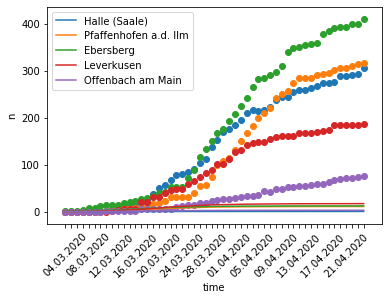

In [12]:
n_sim_spatial = spatialModelFracConn(*(results_spatial.x),
                        nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, t_infectious)

n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, 50, 10):
    n_obs_plt.append(n_obs[i])
    n_sim_plt.append(n_sim_spatial[i])
    names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

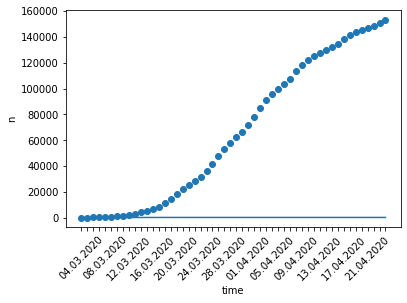

In [4]:
plotSimCuml(dateColNames, n_obs, n_sim_spatial)

With this model we can finally obtain any meaningful values for LKs that did not initially have infections. But the fit isn't quite ideal. Let's see if we can do better with extra information about traffic.